In [3]:
import sys, os
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision('high')
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm

sys.path.append('../src/')
from utils import count_parameters, infinite_dataloader, grab
from nets import SimpleFeedForward, FeedForwardwithEMB
from custom_datasets import ManifoldDataset, Manifold_A_Dataset
from distribution import DistributionDataLoader, distribution_dict
from interpolant_utils import DeconvolvingInterpolant
from callbacks import save_fig_2dsynt_coeff, save_fig_2dsynt_vec, save_fig_manifold
from trainer_si import Trainer
import forward_maps as fwd_maps
import argparse
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# BASEPATH = '/mnt/home/jhan/stoch-int-priors/results'
BASEPATH = '//mnt/ceph/users/cmodi/diffusion_guidance/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("DEVICE : ", device)

DEVICE :  cuda


In [4]:
0.2 * 0.25


0.05

In [5]:
parser = argparse.ArgumentParser(description="")
# parser.add_argument("--dataset", type=str, default="checker", help="dataset")
parser.add_argument("--dataset", type=str, default="moon", help="dataset")
parser.add_argument("--corruption", type=str, default="gaussian_noise", help="corruption")
# parser.add_argument("--corruption", type=str, default="projection_coeff", help="corruption")
parser.add_argument("--corruption_levels", type=float, nargs='+', help="corruption level")
parser.add_argument("--fc_width", type=int, default=256, help="width of the feedforward network")
parser.add_argument("--fc_depth", type=int, default=3, help="depth of the feedforward network")
parser.add_argument("--gamma_scale", type=float, default=0.2, help="gaussian noise level in the interpolant")
parser.add_argument("--diffusion_coef", type=float, default=0.05, help="gaussian noise level for sampling")
parser.add_argument("--train_steps", type=int, default=2000, help="number of channels in model")
parser.add_argument("--batch_size", type=int, default=2048, help="batch size")
parser.add_argument("--learning_rate", type=float, default=5e-4, help="learning rate")
parser.add_argument("--prefix", type=str, default='', help="prefix for folder name")
parser.add_argument("--suffix", type=str, default='', help="suffix for folder name")
parser.add_argument("--lr_scheduler", action='store_true', help="use scheduler if provided, else not")
# parser.add_argument("--clean_data_steps", type=int, default=5000, help="number of clean data steps to use in training")
parser.add_argument("--clean_data_steps", type=int, default=0, help="number of clean data steps to use in training")
parser.add_argument("--ode_steps", type=int, default=40, help="ode steps")
parser.add_argument("--save_and_sample_every", type=int, default=1000, help="save and sample every n steps")
parser.add_argument("--model_path", type=str, default='latest', help="which model to load")
parser.add_argument("--resume_count", type=int, default=1, help="continued training count")
parser.add_argument("--update_transport_every", type=int, default=1, help="continued training count")

args = parser.parse_args(['--corruption_levels', '1.0',
                          '--suffix', 'update1'])

# # Parse arguments
# args = parser.parse_args(['--corruption_levels', '1', '0.01',
#                           '--suffix', 'test'])


# parser = argparse.ArgumentParser(description="")
# parser.add_argument("--dataset", type=str, default="moon", help="dataset")
# parser.add_argument("--corruption", type=str, default="projection_vec", help="corruption")
# # parser.add_argument("--corruption", type=str, default="projection_coeff", help="corruption")
# parser.add_argument("--corruption_levels", type=float, nargs='+', help="corruption level")
# parser.add_argument("--fc_width", type=int, default=256, help="width of the feedforward network")
# parser.add_argument("--fc_depth", type=int, default=3, help="depth of the feedforward network")
# parser.add_argument("--train_steps", type=int, default=20000, help="number of channels in model")
# parser.add_argument("--batch_size", type=int, default=4000, help="batch size")
# parser.add_argument("--learning_rate", type=float, default=2e-4, help="learning rate")
# parser.add_argument("--update_transport_every", type=int, default=128, help="continued training count")
# parser.add_argument("--prefix", type=str, default='', help="prefix for folder name")
# parser.add_argument("--suffix", type=str, default='', help="suffix for folder name")
# parser.add_argument("--lr_scheduler", action='store_true', help="use scheduler if provided, else not")
# parser.add_argument("--clean_data_steps", type=int, default=-1, help="number of clean data steps to use in training")
# parser.add_argument("--ode_steps", type=int, default=40, help="ode steps")
# parser.add_argument("--save_and_sample_every", type=int, default=1000, help="save and sample every n steps")
# parser.add_argument("--model_path", type=str, default='latest', help="which model to load")
# parser.add_argument("--resume_count", type=int, default=1, help="continued training count")

# Parse arguments
# args = parser.parse_args()
# args = parser.parse_args(['--corruption_levels', '1', '0.001',
#                           '--suffix', 'test'])

args = parser.parse_args(['--corruption_levels', '1.0',
                          '--suffix', 'update1'])
# args.update_transport_every = 128
# args = parser.parse_args(['--corruption_levels', '1.0',
#                           '--suffix', 'update512', 
#                          ])

# Parse corruption arguments
corruption = args.corruption # to fix
corruption_levels = args.corruption_levels
if args.corruption == "projection_vec_ds":
    assert args.dataset == "manifold_ds", "For projection_vec_ds, dataset should be manifold_ds"
    dataset_path = f"/mnt/home/jhan/diffusion-priors/experiments/manifold/manifold_dataset_eps{corruption_levels[1]:0.2f}.npz"
    assert os.path.exists(dataset_path), f"Dataset path {dataset_path} does not exist"
    A_dataset = Manifold_A_Dataset(dataset_path)
    dl_A = DataLoader(A_dataset, batch_size = batch_size, shuffle = True, pin_memory = True, num_workers = 1, drop_last = True)
    fwd_func = fwd_maps.corruption_dict[corruption](dl_A)
else:
    try:
        fwd_func = fwd_maps.corruption_dict[corruption](*corruption_levels)
    except Exception as e:
        print("Exception in loading corruption function : ", e)
        sys.exit()
cname = "-".join([f"{i:0.2f}" for i in corruption_levels])
folder = f"{args.dataset}-{corruption}-{cname}"
if args.prefix != "": folder = f"{args.prefix}-{folder}"
if args.suffix != "": folder = f"{folder}-{args.suffix}"
results_folder = f"{BASEPATH}/{folder}/"
os.makedirs(results_folder, exist_ok=True)
print(f"Results will be saved in folder: {results_folder}")
use_latents, latent_dim = fwd_maps.parse_latents(corruption, None)

batch_size = args.batch_size
update_transport_every = args.update_transport_every
print(f"Update transport every : {update_transport_every}")
lr = args.learning_rate
lr_scheduler = args.lr_scheduler
print(args)

Results will be saved in folder: //mnt/ceph/users/cmodi/diffusion_guidance//moon-gaussian_noise-1.00-update1/
Update transport every : 1
Namespace(dataset='moon', corruption='gaussian_noise', corruption_levels=[1.0], fc_width=256, fc_depth=3, gamma_scale=0.2, diffusion_coef=0.05, train_steps=2000, batch_size=2048, learning_rate=0.0005, prefix='', suffix='update1', lr_scheduler=False, clean_data_steps=0, ode_steps=40, save_and_sample_every=1000, model_path='latest', resume_count=1, update_transport_every=1)


In [6]:

if args.dataset in ["checker", "moon"]:
    dim_in = 2
    dataloader = DistributionDataLoader(distribution_dict[args.dataset](device=device), batch_size=batch_size, fwd_func=fwd_func, use_latents=use_latents)
    dataset=None
    if args.corruption.startswith("projection_coeff"):
        save_fig_fn = save_fig_2dsynt_coeff
    else:
        save_fig_fn = save_fig_2dsynt_vec
    clean_data_valid = dataloader.distribution.sample(20000).to(device)
elif args.dataset == 'gmm':
    dim_in = 2
    nmix = 4
    def _compute_mu(i):
        return 5.0 * torch.Tensor([[
                    torch.tensor(i * np.pi / 4).sin(),
                    torch.tensor(i * np.pi / 4).cos()]])
    mus_target = torch.stack([_compute_mu(i) for i in range(nmix)]).squeeze(1)
    var_target = torch.stack([torch.tensor([0.7, 0.7]) for i in range(nmix)])
    distribution = distribution_dict[args.dataset](mus_target, var_target, device=device, ndim=dim_in)
    dataloader = DistributionDataLoader(distribution, batch_size=batch_size, fwd_func=fwd_func, use_latents=use_latents)
    dataset = None
    if args.corruption.startswith("projection_vec"):
        save_fig_fn = save_fig_2dsynt_vec
    elif args.corruption.startswith("projection_coeff"):
        save_fig_fn = save_fig_2dsynt_coeff
    clean_data_valid = dataloader.distribution.sample(10000).to(device)

elif args.dataset == "manifold_ds":
    dim_in = 5
    dataset_path = f"/mnt/home/jhan/diffusion-priors/experiments/manifold/manifold_dataset_eps{corruption_levels[1]:0.2f}.npz"
    assert os.path.exists(dataset_path), f"Dataset path {dataset_path} does not exist"
    if args.corruption.startswith("projection_vec"):
        obs_type = "vec"
    elif args.corruption.startswith("projection_coeff"):
        obs_type = "coeff"
    dataset = ManifoldDataset(dataset_path, obs_type)
    dataloader = None
    save_fig_fn = save_fig_manifold
    clean_data_valid = dataset.x_data.to(device)
else:
    raise ValueError(f"Unknown dataset: {args.dataset}")


# Makde dataset for plotting
corrupted_valid, latents_valid = fwd_func(clean_data_valid, return_latents=True)
latents_valid = latents_valid if use_latents else None

if args.corruption.startswith("projection") and use_latents:
    latent_dim = dim_in * int(args.corruption_levels[0])
else:
    latent_dim = None
if args.corruption == "projection_coeff" and dim_in == int(args.corruption_levels[0]):
    corrupted_valid_plot = torch.linalg.solve(latents_valid, corrupted_valid)
else:
    corrupted_valid_plot = corrupted_valid

valid_data_plot = (clean_data_valid, corrupted_valid_plot, latents_valid)


# ODE

In [7]:
train_num_steps = 5_000
save_and_sample_every = 2000


In [8]:
results_folder

'//mnt/ceph/users/cmodi/diffusion_guidance//moon-gaussian_noise-1.00-update1/'

In [9]:
latents_valid

In [10]:
# Initialize model and train
deconvolver_ode = DeconvolvingInterpolant(
    fwd_func,
    use_latents=use_latents,
    n_steps=args.ode_steps,
    alpha=1.,
    resamples=1, 
    diffusion_coeff=0.,
    gamma_scale=0.
).to(device)


b_ode =  FeedForwardwithEMB(dim_in, 64, [args.fc_width]*args.fc_depth, latent_dim=latent_dim).to(device)
s = None

trainer_ode = Trainer(model=b_ode,
        deconvolver=deconvolver_ode,
        dataloader=dataloader,
        dataset=dataset,
        train_batch_size = batch_size,
        update_transport_every = update_transport_every,
        gradient_accumulate_every = 1,
        train_lr = lr,
        lr_scheduler = lr_scheduler,
        train_num_steps = train_num_steps,
        save_and_sample_every= save_and_sample_every,
        results_folder=results_folder + '-ode/',
        clean_data_steps=args.clean_data_steps,
        callback_fn=save_fig_fn,
        validation_data=valid_data_plot,
        s_model = None
        )

Distributed training not initialized, using single GPU.


  0%|          | 0/5000 [00:00<?, ?it/s]

New best model at step 2000 with loss 0.8174
Saved model at step 2000
New best model at step 4000 with loss 0.7905
Saved model at step 4000
//mnt/ceph/users/cmodi/diffusion_guidance/moon-gaussian_noise-1.00-update1/-ode/losses.png
training complete


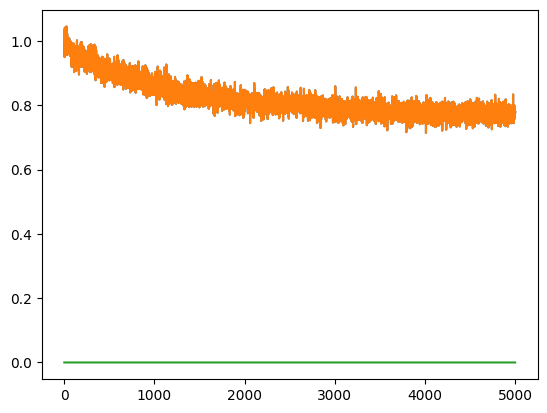

In [11]:
losses_ode = trainer_ode.train()
plt.plot(losses_ode)

Text(0.5, 0.98, 'ODE')

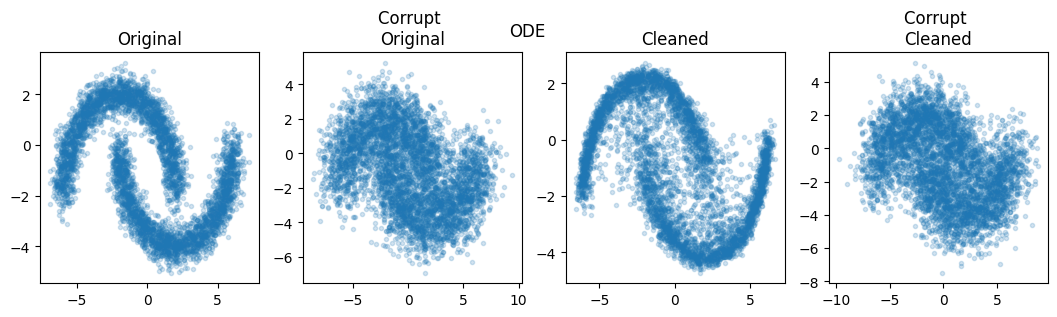

In [12]:
clean = deconvolver_ode.transport(b_ode, corrupted_valid, latent=latents_valid)
# clean = deconvolver.transport(b, corrupted_valid[:5000], latents_valid[:5000])
corrupted_again = deconvolver_ode.push_fwd(clean)

fig, ax = plt.subplots(1, 4, figsize=(13, 3))
ax[0].scatter(*grab(clean_data_valid[:5000].T), marker='.', alpha=0.2)
ax[0].set_title('Original')
ax[1].scatter(*grab(corrupted_valid[:5000].T), marker='.', alpha=0.2)
ax[1].set_title('Corrupt \nOriginal')
ax[2].scatter(*grab(clean[:5000].T), marker='.', alpha=0.2)
ax[2].set_title('Cleaned')
ax[3].scatter(*grab(corrupted_again[:5000].T), marker='.', alpha=0.2)
ax[3].set_title('Corrupt \nCleaned')

plt.suptitle('ODE')
# for axis in ax:
#     axis.set_xlim(-3, 3)
#     axis.set_ylim(-3, 3)

# ODE with stochasticity

In [13]:
# # Initialize model and train
# deconvolver_gode = DeconvolvingInterpolant(
#     fwd_func,
#     use_latents=use_latents,
#     n_steps=args.ode_steps,
#     resamples=2, 
#     alpha=0.9,
#     diffusion_coef=0.0,
#     gamma_scale=0.5
# ).to(device)

# b_gode =  FeedForwardwithEMB(dim_in, 64, [args.fc_width]*args.fc_depth, latent_dim=latent_dim).to(device)

# trainer_gode = Trainer(model=b_gode,
#         deconvolver=deconvolver_gode,
#         dataloader=dataloader,
#         dataset=dataset,
#         train_batch_size = batch_size,
#         update_transport_every = update_transport_every,
#         gradient_accumulate_every = 1,
#         train_lr = lr,
#         lr_scheduler = lr_scheduler,
#         train_num_steps = train_num_steps,
#         save_and_sample_every= save_and_sample_every,
#         results_folder=results_folder[:-1] + '-odestoch/',
#         clean_data_steps=args.clean_data_steps,
#         callback_fn=save_fig_fn,
#         validation_data=valid_data_plot,
#         s_model = None
#         )

In [14]:
# losses_gode = trainer_gode.train()
# plt.plot(losses_gode)

In [15]:
# clean = deconvolver_gode.transport(b_gode, corrupted_valid, latent=latents_valid)
# corrupted_again = deconvolver_gode.push_fwd(clean)

# fig, ax = plt.subplots(1, 4, figsize=(13, 3))
# ax[0].scatter(*grab(clean_data_valid[:5000].T), marker='.', alpha=0.2)
# ax[0].set_title('Original')
# ax[1].scatter(*grab(corrupted_valid[:5000].T), marker='.', alpha=0.2)
# ax[1].set_title('Corrupt \nOriginal')
# ax[2].scatter(*grab(clean[:5000].T), marker='.', alpha=0.2)
# ax[2].set_title('Cleaned')
# ax[3].scatter(*grab(corrupted_again[:5000].T), marker='.', alpha=0.2)
# ax[3].set_title('Corrupt \nCleaned')

# plt.suptitle('ODE')
# # for axis in ax:
# #     axis.set_xlim(-3, 3)
# #     axis.set_ylim(-3, 3)

# SDE

In [18]:
# Initialize model and train
deconvolver_sde = DeconvolvingInterpolant(
    fwd_func,
    use_latents=use_latents,
    n_steps=args.ode_steps,
    alpha=0.9,
    resamples=2, 
    diffusion_coeff=0.1,
    gamma_scale=0.5, 
    sampler='heun'
).to(device)


b_sde =  FeedForwardwithEMB(dim_in, 64, [args.fc_width]*args.fc_depth, latent_dim=latent_dim).to(device)
s =  FeedForwardwithEMB(dim_in, 64, [args.fc_width]*args.fc_depth, latent_dim=latent_dim).to(device)

trainer_sde = Trainer(model=b_sde,
        s_model = s,
        deconvolver=deconvolver_sde,
        dataloader=dataloader,
        dataset=dataset,
        train_batch_size = batch_size,
        update_transport_every = update_transport_every,
        gradient_accumulate_every = 1,
        train_lr = lr,
        lr_scheduler = lr_scheduler,
        train_num_steps = 20_000, #train_num_steps,
        save_and_sample_every= save_and_sample_every,
        results_folder=results_folder[:-1] + '-sde/',
        clean_data_steps=args.clean_data_steps,
        callback_fn=save_fig_fn,
        validation_data=valid_data_plot,
        )



Using heun sampler
Distributed training not initialized, using single GPU.


In [ ]:
losses_sde = trainer_sde.train()
plt.plot(losses_sde)

  0%|          | 0/20000 [00:00<?, ?it/s]

New best model at step 2000 with loss 1.8418
Saved model at step 2000
New best model at step 4000 with loss 1.7903
Saved model at step 4000
Saved model at step 6000
New best model at step 8000 with loss 1.7827
Saved model at step 8000
New best model at step 10000 with loss 1.7559
Saved model at step 10000
Saved model at step 12000
New best model at step 14000 with loss 1.7376
Saved model at step 14000


In [ ]:
clean = deconvolver_sde.transport(b_sde, corrupted_valid, latent=latents_valid, s=s)
corrupted_again = deconvolver_sde.push_fwd(clean)

fig, ax = plt.subplots(1, 4, figsize=(13, 3))
ax[0].scatter(*grab(clean_data_valid[:5000].T), marker='.', alpha=0.2)
ax[0].set_title('Original')
ax[1].scatter(*grab(corrupted_valid[:5000].T), marker='.', alpha=0.2)
ax[1].set_title('Corrupt \nOriginal')
ax[2].scatter(*grab(clean[:5000].T), marker='.', alpha=0.2)
ax[2].set_title('Cleaned')
ax[3].scatter(*grab(corrupted_again[:5000].T), marker='.', alpha=0.2)
ax[3].set_title('Corrupt \nCleaned')

# for axis in ax:
#     axis.set_xlim(-3, 3)
#     axis.set_ylim(-3, 3)

In [ ]:
losses_sde = trainer_sde.train()
plt.plot(losses_sde)

In [ ]:
clean = deconvolver_sde.transport(b_sde, corrupted_valid, latent=latents_valid, s=s)
corrupted_again = deconvolver_sde.push_fwd(clean)

fig, ax = plt.subplots(1, 4, figsize=(13, 3))
ax[0].scatter(*grab(clean_data_valid[:5000].T), marker='.', alpha=0.2)
ax[0].set_title('Original')
ax[1].scatter(*grab(corrupted_valid[:5000].T), marker='.', alpha=0.2)
ax[1].set_title('Corrupt \nOriginal')
ax[2].scatter(*grab(clean[:5000].T), marker='.', alpha=0.2)
ax[2].set_title('Cleaned')
ax[3].scatter(*grab(corrupted_again[:5000].T), marker='.', alpha=0.2)
ax[3].set_title('Corrupt \nCleaned')

# for axis in ax:
#     axis.set_xlim(-3, 3)
#     axis.set_ylim(-3, 3)

In [ ]:
# np.save('./figs/sde_1.00', np.stack([grab(clean_data_valid), grab(corrupted_valid), grab(clean)]))

# compare

Text(0.5, 1.0, 'Cleaned\nSDE')

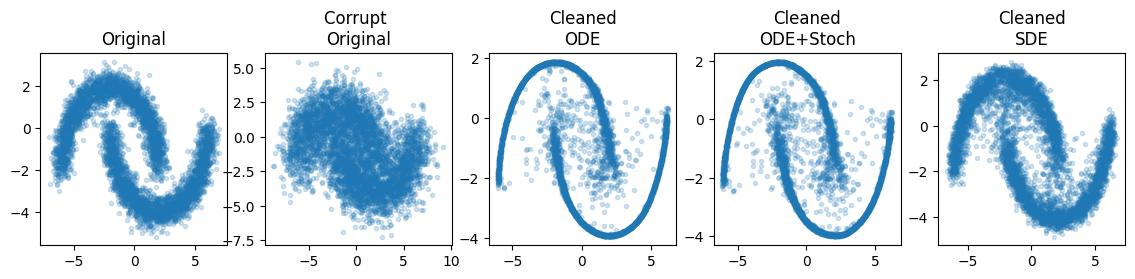

In [57]:
clean_sde = deconvolver_sde.transport(b_sde, corrupted_valid, latent=latents_valid, s=s)
clean_ode = deconvolver_sde.transport(b_ode, corrupted_valid, latent=latents_valid, s=None)
clean_gode = deconvolver_sde.transport(b_gode, corrupted_valid, latent=latents_valid, s=None)

fig, ax = plt.subplots(1, 5, figsize=(14, 2.5))
ax[0].scatter(*grab(clean_data_valid[:5000].T), marker='.', alpha=0.2)
ax[0].set_title('Original')
ax[1].scatter(*grab(corrupted_valid[:5000].T), marker='.', alpha=0.2)
ax[1].set_title('Corrupt \nOriginal')
ax[2].scatter(*grab(clean_ode[:5000].T), marker='.', alpha=0.2)
ax[2].set_title('Cleaned\nODE')
ax[3].scatter(*grab(clean_gode[:5000].T), marker='.', alpha=0.2)
ax[3].set_title('Cleaned\nODE+Stoch')
ax[4].scatter(*grab(clean_sde[:5000].T), marker='.', alpha=0.2)
ax[4].set_title('Cleaned\nSDE')

# for axis in ax:
#     axis.set_xlim(-3, 3)
#     axis.set_ylim(-3, 3)

In [58]:
folder

'moon-gaussian_noise-1.00-update1'

In [59]:
# tosave = np.stack((grab(clean_data_valid[:5000].T), grab(corrupted_valid[:5000].T),
#                 grab(clean_ode[:5000].T), grab(clean_gode[:5000].T),  grab(clean_sde[:5000].T)), axis=2)
# np.save(f'./figs/{folder}', tosave)


### N = 1.0, g = 0.5, s = 0.2, t = 128

Text(0.5, 1.0, 'Cleaned\nSDE')

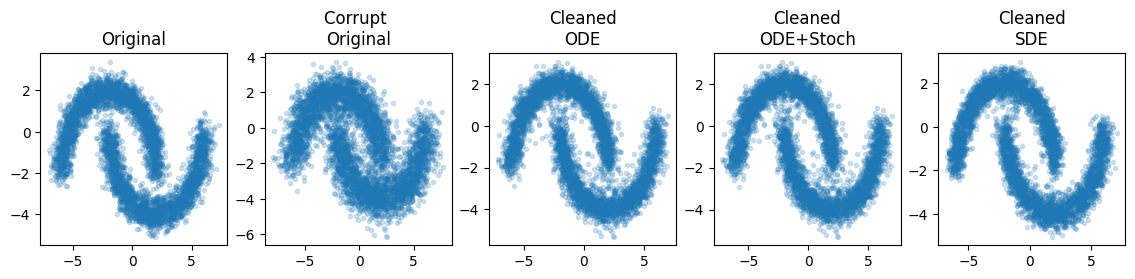

In [22]:
clean_sde = deconvolver_sde.transport(b_sde, corrupted_valid, latent=latents_valid, s=s)
clean_ode = deconvolver_sde.transport(b_ode, corrupted_valid, latent=latents_valid, s=None)
clean_gode = deconvolver_sde.transport(b_gode, corrupted_valid, latent=latents_valid, s=None)

fig, ax = plt.subplots(1, 5, figsize=(14, 2.5))
ax[0].scatter(*grab(clean_data_valid[:5000].T), marker='.', alpha=0.2)
ax[0].set_title('Original')
ax[1].scatter(*grab(corrupted_valid[:5000].T), marker='.', alpha=0.2)
ax[1].set_title('Corrupt \nOriginal')
ax[2].scatter(*grab(clean_ode[:5000].T), marker='.', alpha=0.2)
ax[2].set_title('Cleaned\nODE')
ax[3].scatter(*grab(clean_gode[:5000].T), marker='.', alpha=0.2)
ax[3].set_title('Cleaned\nODE+Stoch')
ax[4].scatter(*grab(clean_sde[:5000].T), marker='.', alpha=0.2)
ax[4].set_title('Cleaned\nSDE')

# for axis in ax:
#     axis.set_xlim(-3, 3)
#     axis.set_ylim(-3, 3)

In [31]:
results_folder

'//mnt/ceph/users/cmodi/diffusion_guidance//moon-gaussian_noise-0.50-update1/'

###  N = 1.0, g = 0.5, s = 0.2, t = 1

Text(0.5, 1.0, 'Cleaned\nSDE')

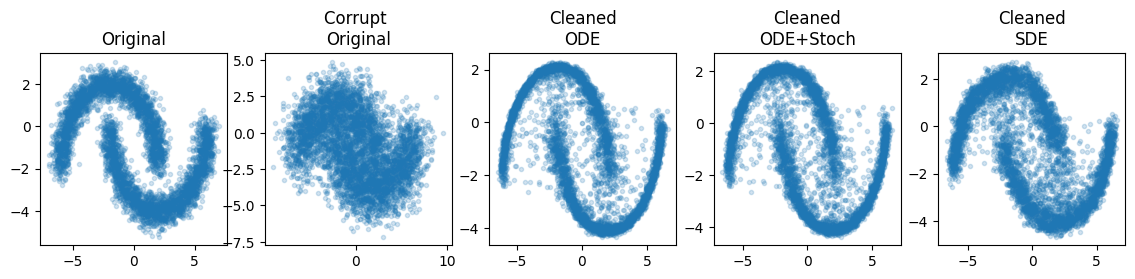

In [16]:
# clean_sde = deconvolver_sde.transport(b_sde, corrupted_valid, latent=latents_valid, s=s)
# clean_ode = deconvolver_sde.transport(b_ode, corrupted_valid, latent=latents_valid, s=None)
# clean_gode = deconvolver_sde.transport(b_gode, corrupted_valid, latent=latents_valid, s=None)

# fig, ax = plt.subplots(1, 5, figsize=(14, 2.5))
# ax[0].scatter(*grab(clean_data_valid[:5000].T), marker='.', alpha=0.2)
# ax[0].set_title('Original')
# ax[1].scatter(*grab(corrupted_valid[:5000].T), marker='.', alpha=0.2)
# ax[1].set_title('Corrupt \nOriginal')
# ax[2].scatter(*grab(clean_ode[:5000].T), marker='.', alpha=0.2)
# ax[2].set_title('Cleaned\nODE')
# ax[3].scatter(*grab(clean_gode[:5000].T), marker='.', alpha=0.2)
# ax[3].set_title('Cleaned\nODE+Stoch')
# ax[4].scatter(*grab(clean_sde[:5000].T), marker='.', alpha=0.2)
# ax[4].set_title('Cleaned\nSDE')

# # for axis in ax:
# #     axis.set_xlim(-3, 3)
# #     axis.set_ylim(-3, 3)

[]

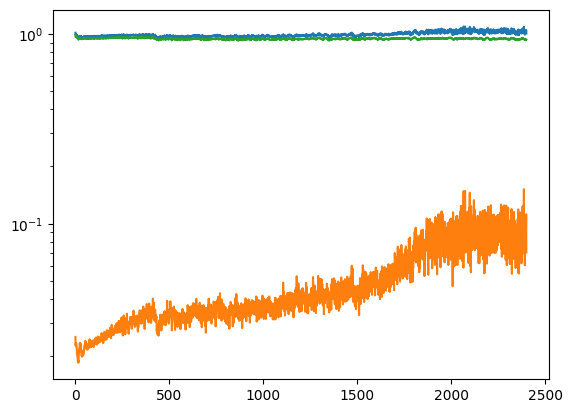

In [14]:
f = np.load('/mnt/ceph/users/cmodi/diffusion_guidance/singleview/cifar10-gaussian_blur-1.00-0.10-sde-g0.10-dc0.025-v3-cds5k-heun/losses.npy')
plt.plot(f)
plt.semilogy()

[]

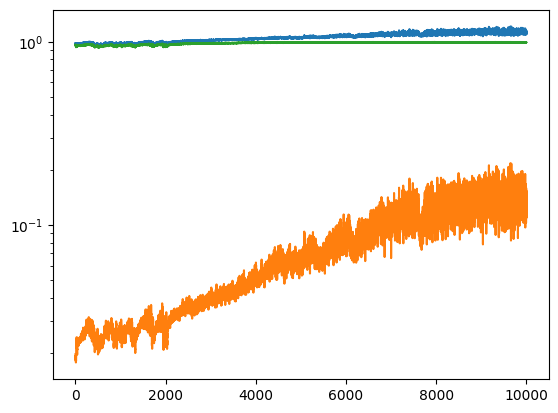

In [13]:
f = np.load('/mnt/ceph/users/cmodi/diffusion_guidance/singleview/cifar10-gaussian_blur-1.00-0.10-sde-g0.10-dc0.025-v3-cds5k/losses.npy')
plt.plot(f)
plt.semilogy()